### Food Image Classification With a CNN w/ Transfer Learning via VGG16

In [1]:
# load the necessary packages
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.layers import Input, AveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
import pandas as pd

import os
import numpy as np
import matplotlib.pyplot as plt

### Load and Preprocess Data for Model

In [2]:
# setup model architechture
# remove dense top layers from pre-trained model
base_model = VGG16(weights='imagenet', 
              include_top=False, 
              input_tensor=(Input(shape=(180,180,3)))
             )
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

In [3]:
#add in final layers of model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4,4))(head_model)
head_model = Flatten(name='flatten')(head_model)
head_model = Dense(180, activation='relu')(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(101, activation='softmax')(head_model)

#place new head model on top of pre-trained network
model = Model(inputs=base_model.input, outputs=head_model)

#freeze training in pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [4]:
# compile model
model.compile(optimizer='adam',
              loss='cosine_similarity',
              metrics=['accuracy'])

In [5]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    save_weights_only=True,
    save_freq=5)

# initialize early stopping callback
es_callback = EarlyStopping(monitor="val_loss", patience=3)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

In [7]:
batch_size = 50
epochs = 15
IMG_HEIGHT = 180
IMG_WIDTH = 180
train_dir = 'data/resized/train'
test_dir = 'data/resized/test'
dropout_rate = 0.15

In [8]:
train_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

In [9]:
# initialize training image iterator
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                          directory=train_dir,
                                                          shuffle=True,
                                                          target_size=(IMG_HEIGHT,IMG_WIDTH))

Found 75750 images belonging to 101 classes.


In [10]:
# initialize test image iterator
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                          directory=test_dir,
                                                          shuffle=True,
                                                          target_size=(IMG_HEIGHT,IMG_WIDTH))

Found 25250 images belonging to 101 classes.


In [11]:
# train model
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=75750//batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=25250//batch_size,
    workers=1,
    use_multiprocessing=False,
    callbacks=[es_callback]
)

Epoch 1/15
1515/1515 [==============================] - 1070s 706ms/step - loss: -0.1746 - accuracy: 0.1012 - val_loss: -0.2722 - val_accuracy: 0.2172
Epoch 2/15
1515/1515 [==============================] - 1062s 701ms/step - loss: -0.2408 - accuracy: 0.1685 - val_loss: -0.3183 - val_accuracy: 0.2600
Epoch 3/15
1515/1515 [==============================] - 1059s 699ms/step - loss: -0.2626 - accuracy: 0.1920 - val_loss: -0.3372 - val_accuracy: 0.2768
Epoch 4/15
1515/1515 [==============================] - 1053s 695ms/step - loss: -0.2760 - accuracy: 0.2058 - val_loss: -0.3487 - val_accuracy: 0.2891
Epoch 5/15
1515/1515 [==============================] - 1063s 702ms/step - loss: -0.2845 - accuracy: 0.2152 - val_loss: -0.3580 - val_accuracy: 0.2987
Epoch 6/15
1515/1515 [==============================] - 1091s 720ms/step - loss: -0.2895 - accuracy: 0.2204 - val_loss: -0.3593 - val_accuracy: 0.2992
Epoch 7/15
1515/1515 [==============================] - 1070s 706ms/step - loss: -0.2949 - acc

In [12]:
# if there is not a saved model, save model for future use
if not os.path.isdir('./tmp/models'):
    os.makedirs('./tmp/models')
model.save('tmp/models/CNN_VGG16_MODEL_V1.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


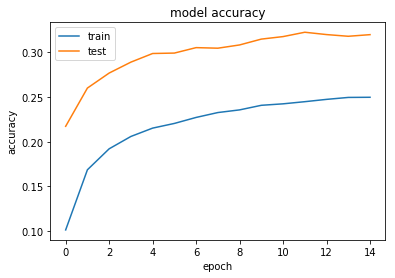

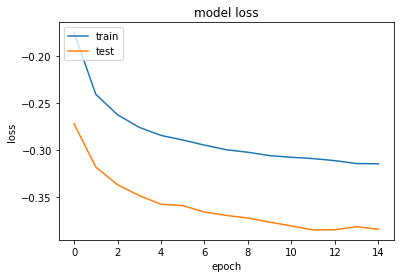

In [13]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
# train model
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=75750//batch_size,
    epochs=35,
    validation_data=test_data_gen,
    validation_steps=25250//batch_size,
    workers=1,
    use_multiprocessing=False,
    callbacks=[es_callback]
)

Epoch 1/35
1515/1515 [==============================] - 1055s 696ms/step - loss: -0.3174 - accuracy: 0.2530 - val_loss: -0.3829 - val_accuracy: 0.3200
Epoch 2/35
1515/1515 [==============================] - 1049s 693ms/step - loss: -0.3188 - accuracy: 0.2538 - val_loss: -0.3872 - val_accuracy: 0.3224
Epoch 3/35
1515/1515 [==============================] - 1047s 691ms/step - loss: -0.3210 - accuracy: 0.2580 - val_loss: -0.3884 - val_accuracy: 0.3241
Epoch 4/35
1515/1515 [==============================] - 1044s 689ms/step - loss: -0.3209 - accuracy: 0.2585 - val_loss: -0.3878 - val_accuracy: 0.3235
Epoch 5/35
1515/1515 [==============================] - 1041s 687ms/step - loss: -0.3218 - accuracy: 0.2585 - val_loss: -0.3911 - val_accuracy: 0.3264
Epoch 6/35
1515/1515 [==============================] - 1041s 687ms/step - loss: -0.3233 - accuracy: 0.2593 - val_loss: -0.3900 - val_accuracy: 0.3251
Epoch 7/35
1515/1515 [==============================] - 1041s 687ms/step - loss: -0.3242 - acc

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


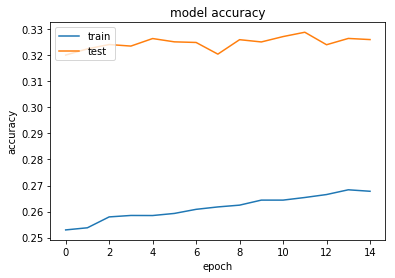

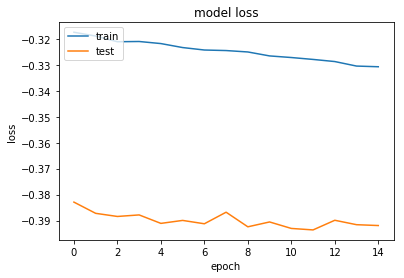

In [15]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()